<h1 align='center'> Time Series Experiments </h1>

In this notebook with the help of nixtla we will implement all the models we have discussed about on our previous documents.

Algorithms to try out: 

In [29]:
!pip3 install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 424.4 kB/s eta 0:00:0031m1.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 457.1 kB/s eta 0:00:001m414.4 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 149.3 kB/s eta 0:00:001m390.5 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 331.2 kB/s eta 0:00:001m316.3 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 471.3 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 147.2 kB/s eta 0:00:00m eta 0:00:010:00:08
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 213.1 kB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 970.9 kB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 1.0 MB/s eta 0:00:001.1 MB/s eta 0:00:01
   ━━

In [5]:
from prophet import Prophet
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator,YearLocator
import pandas as pd
from statsforecast import StatsForecast
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np 

<h3> Data Checking out </h3>
We are visualizing how the dataset looks like in general 

,Date,Price
0,2025-01-06,77149
1,2025-01-03,76813
2,2025-01-02,76849
3,2025-01-01,76214
4,2024-12-31,76232
...,...,...
2843,2014-01-06,29119
2844,2014-01-04,29279
2845,2014-01-03,29727
2846,2014-01-02,29975


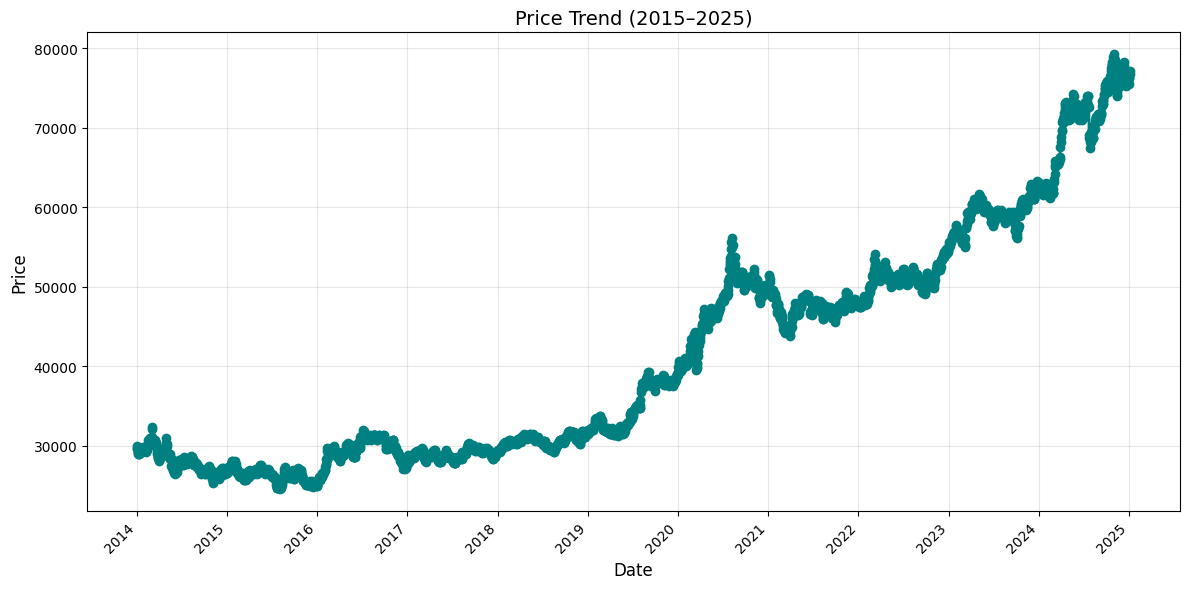

In [3]:
df=pd.read_csv('Gold Price.csv')

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # ensure datetime conversion

display(df[['Date','Price']])
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], marker='o', color='teal', linewidth=2)

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator(1))  # tick every year
ax.xaxis.set_major_formatter(DateFormatter("%Y"))  # format as 2015, 2016, etc.

plt.gcf().autofmt_xdate(rotation=45)  # rotate date labels for readability
plt.title("Price Trend (2015–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<h3> Prophet working </h3>

17:01:19 - cmdstanpy - INFO - Chain [1] start processing
17:01:24 - cmdstanpy - INFO - Chain [1] done processing



✅ Model Evaluation:
MAE  = 1373.25
RMSE = 1732.34
MAPE = 1.81%


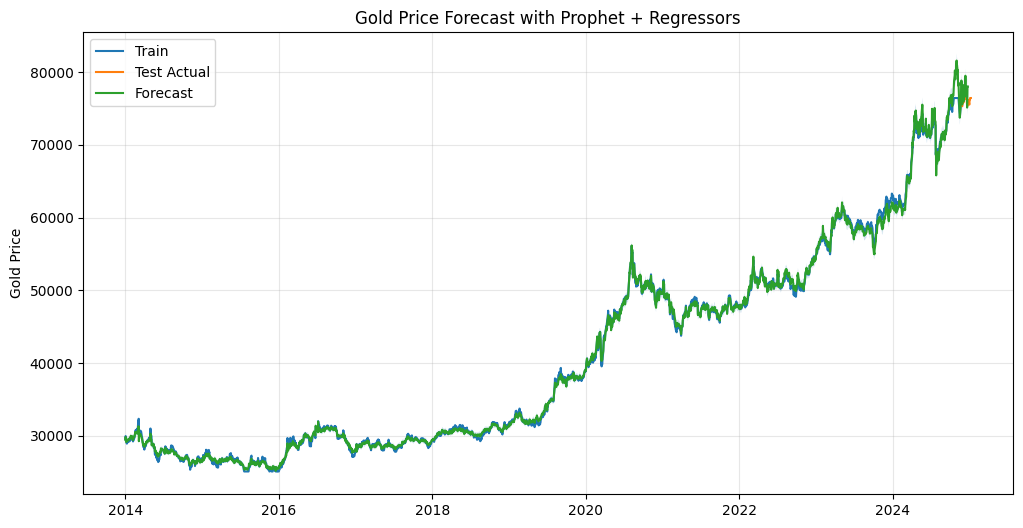

In [ ]:
df = pd.read_csv("Gold Price.csv")

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Keep only needed cols (rename your Price column to match)
df = df[['Date','Price','Open','High','Low','Volume','Chg%']]
df = df.dropna().reset_index(drop=True)

# Remove duplicates & sort
df = df.drop_duplicates(subset=['Date']).sort_values("Date").reset_index(drop=True)

# Winsorize extreme price spikes
q_low  = df['Price'].quantile(0.01)
q_high = df['Price'].quantile(0.99)
df['Price'] = df['Price'].clip(q_low, q_high)

# ✅ Fix Chg% '%' sign if exists (convert to float)
df['Chg%'] = df['Chg%'].astype(str).str.replace('%','', regex=False).astype(float)

# ✅ Log-transform price (reduces effect of jumps)
df['y'] = np.log(df['Price'])
df['ds'] = df['Date']

# -----------------------------------------------------
# 2️⃣ Feature Scaling (Important for Prophet regressors)
# -----------------------------------------------------
reg_cols = ['Open','High','Low','Volume','Chg%']
scaler = StandardScaler()
df[reg_cols] = scaler.fit_transform(df[reg_cols])

# -----------------------------------------------------
# 3️⃣ Train/Test Split
# -----------------------------------------------------
test_days = 180
train = df.iloc[:-test_days].copy()
test  = df.iloc[-test_days:].copy()

# -----------------------------------------------------
# 4️⃣ Prophet Model + Regressors
# -----------------------------------------------------
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.5
)

# Add regressors
for col in reg_cols:
    m.add_regressor(col)

m.fit(train)

# -----------------------------------------------------
# 5️⃣ Future DF (WITH regressors!)
# -----------------------------------------------------
future = m.make_future_dataframe(periods=test_days, freq="D")

# Merge regressors
future = future.merge(df[['ds'] + reg_cols], on='ds', how='left')

# ✅ Fill future NaN regressor values with last known value
for col in reg_cols:
    future[col] = future[col].fillna(df[col].iloc[-1])

forecast = m.predict(future)

# Get test forecast
forecast_test = forecast.iloc[-test_days:].copy()

# Convert log back → price
true = np.exp(test['y'])
pred = np.exp(forecast_test['yhat'])

# -----------------------------------------------------
# 6️⃣ Metrics
# -----------------------------------------------------
mae  = mean_absolute_error(true, pred)
rmse = np.sqrt(mean_squared_error(true, pred))
mape = np.mean(np.abs((true - pred) / true)) * 100

print(f"\n✅ Model Evaluation:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")

# -----------------------------------------------------
# 7️⃣ Plot
# -----------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(train['ds'], np.exp(train['y']), label="Train")
plt.plot(test['ds'], true, label="Test Actual")
plt.plot(forecast['ds'], np.exp(forecast['yhat']), label="Forecast")
plt.fill_between(
    forecast['ds'],
    np.exp(forecast['yhat_lower']),
    np.exp(forecast['yhat_upper']),
    alpha=0.2
)
plt.title("Gold Price Forecast with Prophet + Regressors")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [14]:
def predict_price(date_input):
    """
    Returns the predicted gold price for a given future date.
    """
    date_input = pd.to_datetime(date_input)
    future_df = pd.DataFrame({'ds': [date_input]})

    # Fill regressors with last known values
    for col in reg_cols:  
        future_df[col] = df[col].iloc[-1]

    # Predict
    forecast_result = m.predict(future_df)

    # Inverse log transform to get actual price
    predicted_value = np.exp(forecast_result['yhat'].values[0])
    lower = np.exp(forecast_result['yhat_lower'].values[0])
    upper = np.exp(forecast_result['yhat_upper'].values[0])

    print(f"Predicted Price for {date_input.date()}: {predicted_value:.2f} "
          f"(95% CI: {lower:.2f} – {upper:.2f})")

# Example
predict_price("2024-05-01")


Predicted Price for 2024-05-01: 80381.35 (95% CI: 79258.07 – 81410.30)
